* Guy Kabiri (גיא כבירי)
* https://www.kaggle.com/guykabiri

# Intro
In this competition I will investigate the data of passengers who boarded the Titanic.  
I will try to study the connection between the different features in this data in order to create a model which will be able to predict whether a passenger survived or not.  
I will use two types of models with different features to find the best model for this data.
* SGD - a GD-like linear regression algorithm.
* MLP - an artificial nueral network.

# Imports

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neural_network

# Import The Data

In [ ]:
train_csv = pd.read_csv('../input/titanic/train.csv')
titanic_df = pd.DataFrame(train_csv)
test_csv = pd.read_csv('../input/titanic/test.csv')
test = pd.DataFrame(test_csv)

# Explore The Data

First of all, let's see the keys.

In [ ]:
display(titanic_df.keys())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Understanding the keys meaning:
* `PassengareId` - Id of the passenger .
* `Survived` - Whether the passenger survives or not.
* `Pclass` - The ticket class (SES)
* `Name` - Name of the passenger.
* `Sex` - Gender of the passenger.
* `Age` - Age of the passenger.
* `SibSp` - Number of siblings and spouse.
* `Parch` - Number of parents and children.
* `Ticket` - Ticket number.
* `Fare` - How much the passenger paid.
* `Cabin` - Cabin of the passenger.
* `Embarked` - Which port the passenger borded.

## Variable Analysis
* Categorical Variables: Survived, Sex, Cabin and Embarked.
* Ordinal Variables: Pclass, SubSp and Parch
* Numerical Variables: Age and Fare.

Now let's observe the data and it's structure.
It contains 891 rows with 11 features and the target which means if a passenger survived or not.

In [ ]:
survived = titanic_df["Survived"]
titanic_df = titanic_df.drop("Survived", axis=1)
titanic_df.insert(0, "Survived", survived)
display(titanic_df)
titanic_df.info()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Handle Non-Numerical Variables and Missing Values


In [ ]:
titanic_df.isna().sum()

Survived         0
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Name Variable:
The name seem to be irrelevent to the chance of a passenger to survive, but we can use it to extract a passenger's title into a `Title` categorical variable.
First let's see all the different titles the passengers have.

In [ ]:
titanic_df["Title"] = titanic_df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(titanic_df["Title"], titanic_df["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
pd.crosstab(titanic_df.Title ,titanic_df.Sex).T.style.background_gradient() #Checking the Initials with the Sex

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


There are a lot of titles, some of them can be combined.
* Combine all the rates titles into `Rare`.
* Combine the variante of `Miss`.
* Combine the variante of `Msr`.

In [ ]:
titanic_df["Title"] = titanic_df["Title"].replace(["Lady", "Countess","Capt", "Col",\
 	"Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Other")

titanic_df["Title"] = titanic_df["Title"].replace("Mlle", "Miss")
titanic_df["Title"] = titanic_df["Title"].replace("Ms", "Miss")
titanic_df["Title"] = titanic_df["Title"].replace("Mme", "Mrs")

pd.crosstab(titanic_df.Title ,titanic_df.Survived, values=titanic_df.Age, aggfunc='mean').T.style.background_gradient() #Checking the Initials with the Sex

Title,Master,Miss,Mr,Mrs,Other
Survived,,,,,
0,5.400000,18.853659,32.231118,36.086957,45.214286
1,3.984286,22.981481,33.044776,35.709302,46.125000


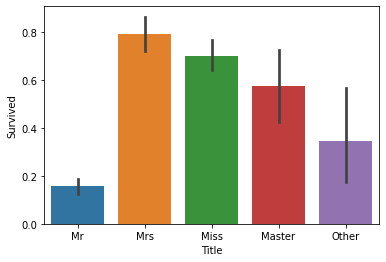

In [ ]:
sns.barplot(x="Title", y="Survived", data=titanic_df)

Now the `Title` variable can be converted into a categorical variable.

In [ ]:
titanic_df["Title_cat"] = titanic_df["Title"].map({'Mr' : 0, 'Mrs' : 1, 'Miss' : 2, 'Master' : 3, 'Other' : 4})
display(titanic_df[["Title", "Title_cat"]])

,Title,Title_cat
0,Mr,0
1,Mrs,1
2,Miss,2
3,Mrs,1
4,Mr,0
...,...,...
886,Other,4
887,Miss,2
888,Miss,2
889,Mr,0


In [ ]:
titanic_df[["Title", "Title_cat"]].isna().any()

Title        False
Title_cat    False
dtype: bool

Now let's perform this manipulation on the test as well.

In [ ]:
test["Title"] = test["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

test["Title"] = test["Title"].replace(["Lady", "Countess","Capt", "Col",\
 	"Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Other")

test["Title"] = test["Title"].replace("Mlle", "Miss")
test["Title"] = test["Title"].replace("Ms", "Miss")
test["Title"] = test["Title"].replace("Mme", "Mrs")

test["Title_cat"] = test["Title"].map({'Mr' : 0, 'Mrs' : 1, 'Miss' : 2, 'Master' : 3, 'Other' : 4})

test["Title_cat"].isna().any()

False

### Embarked Variable:
`Embarked` indicates in which port a passenger boarded the Titanic.  
It could be crutial to determine whether a passenger survived or not becuase it might indicate on a passenger's room location on the titanic.

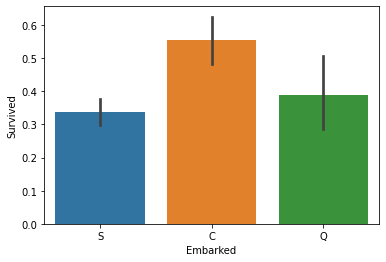

In [ ]:
sns.barplot(x="Embarked", y="Survived", data=titanic_df)

It looks like there are some diffrences in surviving chances between the different `Embarked` locations.  
There are only 3 unique values, it will be converted into 3 binary variables.
But before we change the variavble into a numerical one, we need to fill the missing values, it can be filled with the most common value.

In [ ]:
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(titanic_df["Embarked"].mode()[0])
titanic_df["Embarked_s"] = titanic_df["Embarked"].map({ 'S' : 1, 'C' : 0, 'Q' : 0, np.nan : 0}).astype(int)
titanic_df["Embarked_c"] = titanic_df["Embarked"].map({ 'S' : 0, 'C' : 1, 'Q' : 0, np.nan : 0}).astype(int)
titanic_df["Embarked_q"] = titanic_df["Embarked"].map({ 'S' : 0, 'C' : 0, 'Q' : 1, np.nan : 0}).astype(int)

display(titanic_df[["Embarked", "Embarked_s", "Embarked_c", "Embarked_q"]])
titanic_df["Embarked"].isna().any()

,Embarked,Embarked_s,Embarked_c,Embarked_q
0,S,1,0,0
1,C,0,1,0
2,S,1,0,0
3,S,1,0,0
4,S,1,0,0
...,...,...,...,...
886,S,1,0,0
887,S,1,0,0
888,S,1,0,0
889,C,0,1,0


False

The test dataset does not miss any `Embarked` values, let's just convert it to 3 binary variables as well.

In [ ]:
test["Embarked_s"] = test["Embarked"].map({ 'S' : 1, 'C' : 0, 'Q' : 0, np.nan : 0}).astype(int)
test["Embarked_c"] = test["Embarked"].map({ 'S' : 0, 'C' : 1, 'Q' : 0, np.nan : 0}).astype(int)
test["Embarked_q"] = test["Embarked"].map({ 'S' : 0, 'C' : 0, 'Q' : 1, np.nan : 0}).astype(int)

test[["Embarked_s", "Embarked_c", "Embarked_q"]].isna().any()

Embarked_s    False
Embarked_c    False
Embarked_q    False
dtype: bool

### Sex Variable:
The gender of a passenger might have a strong connection to surviving chances because rescures might help first to women.


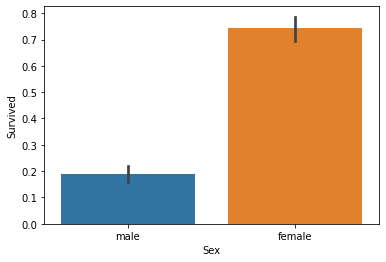

In [ ]:
sns.barplot(x="Sex", y="Survived", data=titanic_df)

As predicted, female had much higher chance to survive.  
`Sex` is a non-numerical column, we will convert into two binary variables `Male`, and `Female`.

In [ ]:
titanic_df["Male"] = 0
titanic_df["Female"] = 0
titanic_df["Male"] = titanic_df["Sex"].map( {'female': 0, 'male': 1} ).astype(int)
titanic_df["Female"] = titanic_df["Sex"].map( {'male': 0, 'female': 1} ).astype(int)
display(titanic_df[["Sex", "Male", "Female"]])

,Sex,Male,Female
0,male,1,0
1,female,0,1
2,female,0,1
3,female,0,1
4,male,1,0
...,...,...,...
886,male,1,0
887,female,0,1
888,female,0,1
889,male,1,0


Convert the test dataset to binary as well.

In [ ]:
test["Male"] = 0
test["Female"] = 0
test["Male"] = test["Sex"].map( {'female': 0, 'male': 1} ).astype(int)
test["Female"] = test["Sex"].map( {'male': 0, 'female': 1} ).astype(int)
test[["Male", "Female"]].isna().any()

Male      False
Female    False
dtype: bool

### Pclass Variable:
`Pclass` indicates a passenger class, it indicates his room location and could affect his surviving chances.

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


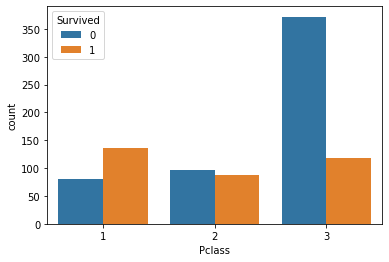

In [ ]:
temp = pd.crosstab(titanic_df.Pclass ,titanic_df.Survived, values=titanic_df.Survived, aggfunc='count').T.style.background_gradient() #Checking the Initials with the Sex
display(temp)
sns.countplot('Pclass',data=titanic_df, hue='Survived')

It is clear that a passenger from 1st class and 2nd class has much more chances to survive compare to 3rd class passengers.

### Age Variable:
`Age` missing 177 value, not too much in terms of this data size, it can be filled with the median value of passengers with similar values, to decide which values, let's see the correlation between `Age` and the other features.

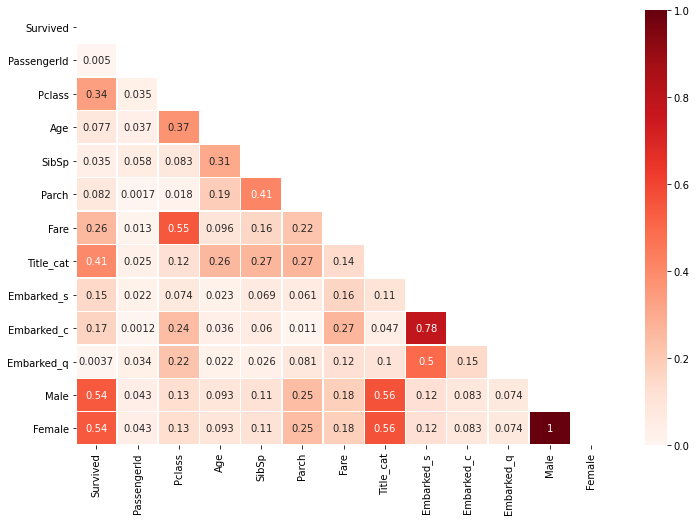

In [ ]:
corr = abs(titanic_df.corr())    # get the data correlation
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1, linewidth=.5)
plt.show()

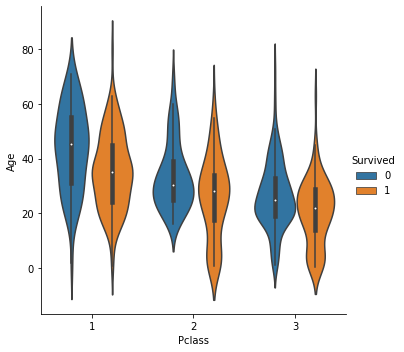

In [ ]:
sns.catplot(y="Age", x="Pclass", hue="Survived", kind="violin", data=titanic_df)

It look like there is a dipendency between `Age`, `Pclass`, and `Title_cat`.
Let's try to fill the emtpy `Age` values with the means of those 2 variables.

In [ ]:
age_mean = titanic_df.groupby(["Title_cat", "Pclass"])["Age"].mean()
print(age_mean)

Title_cat  Pclass
0          1         41.580460
           2         32.768293
           3         28.724891
1          1         40.400000
           2         33.682927
           3         33.515152
2          1         29.744681
           2         22.560606
           3         16.123188
3          1          5.306667
           2          2.258889
           3          5.350833
4          1         47.571429
           2         42.000000
Name: Age, dtype: float64


In [ ]:
for i in range(titanic_df["Title_cat"].nunique()):
     for j in range(age_mean[i].shape[0]):
            titanic_df.loc[ (titanic_df.Age.isnull()) & (titanic_df.Title_cat == i) & (titanic_df.Pclass == j +1 ), 'Age'] = age_mean[i][j+1]

                
print(titanic_df["Age"].isna().any())            
print(titanic_df["Age"])

False
0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    16.123188
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64


We need to fill the missing `Age` values in the test dataset.

In [ ]:
age_mean_test = test.groupby(["Title_cat", "Pclass"])["Age"].mean()
for i in range(test["Title_cat"].nunique()):
     for j in range(age_mean_test[i].shape[0]):
            test.loc[ (test.Age.isnull()) & (test.Title_cat == i) & (test.Pclass == j +1 ), 'Age'] = age_mean_test[i][j+1]
            
test.Age.isna().any()

False

### Back to `Title`
Now after done handling the `Age` feature, we can convert the `Title_cat` into seperate binary features.

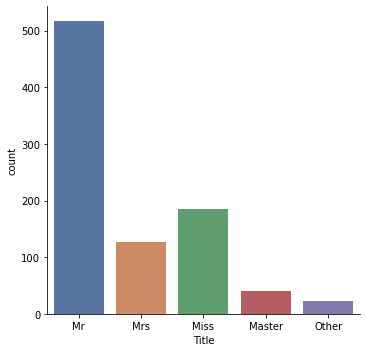

In [ ]:
sns.catplot(x="Title", kind="count", palette=sns.color_palette("deep"), data=titanic_df)

In [ ]:
def convert_titles_binary(data):
    data["Mr"] = 0
    data["Mrs"] = 0
    data["Miss"] = 0
    data["Master"] = 0
    data["Mr"] = data["Title"].map({'Mr' : 1, 'Mrs' : 0, 'Miss' : 0, 'Master' : 0, 'Other' : 0})
    data["Mrs"] = data["Title"].map({'Mr' : 0, 'Mrs' : 1, 'Miss' : 0, 'Master' : 0, 'Other' : 0})
    data["Miss"] = data["Title"].map({'Mr' : 0, 'Mrs' : 0, 'Miss' : 1, 'Master' : 0, 'Other' : 0})
    data["Master"] = data["Title"].map({'Mr' : 0, 'Mrs' : 0, 'Miss' : 0, 'Master' : 1, 'Other' : 0})

convert_titles_binary(titanic_df)
convert_titles_binary(test)

titanic_df[["Mr", "Mrs", "Miss", "Master"]].isna().any()
test[["Mr", "Mrs", "Miss", "Master"]].isna().any()

Mr        False
Mrs       False
Miss      False
Master    False
dtype: bool

### Cabin Variable
`Cabin` which indicates where a passenger was staying at the titanic, is missing 687 values out of 891, that's about 77% of missing values.
For now we will try to drop that variable from this model and will see if adding it later on will improve the results.


In [ ]:
titanic_df.drop("Cabin", axis=1, inplace=True)
print(titanic_df.isna().any())

test.drop("Cabin", axis=1, inplace=True)
print(test.isna().any())

Survived       False
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
Title          False
Title_cat      False
Embarked_s     False
Embarked_c     False
Embarked_q     False
Male           False
Female         False
Mr             False
Mrs            False
Miss           False
Master         False
dtype: bool
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare            True
Embarked       False
Title          False
Title_cat      False
Embarked_s     False
Embarked_c     False
Embarked_q     False
Male           False
Female         False
Mr             False
Mrs            False
Miss           False
Master         False
dtype: bool


## Feature Engeneering

`Parch` and `SibSp` could be merged into one `FamilySize` variable.

In [ ]:
titanic_df["FamilySize"] = titanic_df["Parch"] + titanic_df["SibSp"] + 1
titanic_df[["FamilySize", "Survived"]].groupby(["FamilySize"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Creating the `FamilySize` variable for the test dataset as well.

In [ ]:
test["FamilySize"] = test["Parch"] + test["SibSp"] + 1

We can see that when a passenger has some relatives traveled with him, he had some better chances to survived.  
We can create another feature that might increase the model accuracy.  
`IsAlone` feature will indicate whether a passenger was traveling alone or with relatives.

In [ ]:
titanic_df['IsAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1

test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

We can assume that as the age growth, the class of a passenger could growth too, lets see a graph to demonstrate.

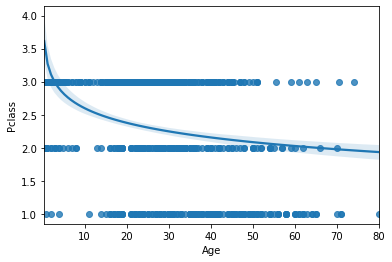

In [ ]:
sns.regplot(x="Age", y="Pclass", data=titanic_df, logx=True)

We know the 1st class is better than 2nd class, and 2nd class is better than 3rd class.  
In this graph we can actually see that the more a passenger is older, his class is higher.

As observed before, it look like `Pclass`, and `Age` have some correlation between them, we may assume that the age of a passenger's may indicates which class he was travled at.  
Older people sometimes tend to have more money and it could indicate they traveled in higher class.  
We will try to create a new feature `AgePclass` as a multiplation between those two features.

In [ ]:
titanic_df["AgePclass"] = titanic_df["Age"] * titanic_df["Pclass"]
test["AgePclass"] = test["Age"] * test["Pclass"]

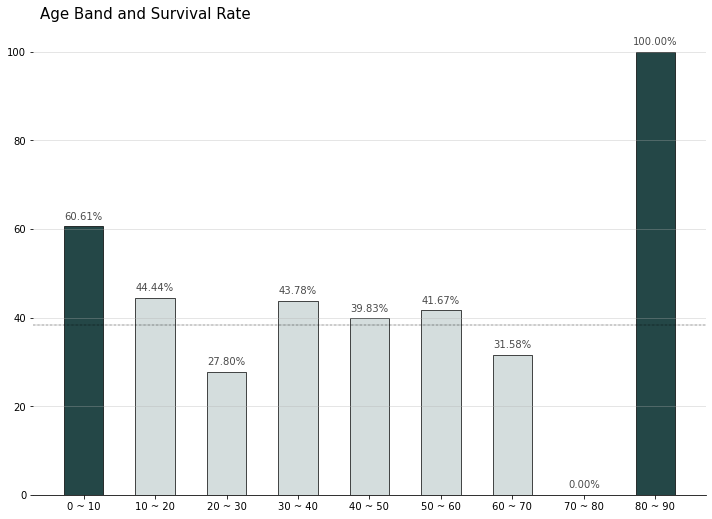

In [ ]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

        
titanic_df['age_band'] = titanic_df['Age'].apply(age_band)
titanic_age = titanic_df[['age_band', 'Survived']].groupby('age_band')['Survived'].value_counts().sort_index().unstack().fillna(0)
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# ax2
color_map = ['#d4dddd' for _ in range(9)]
color_map[0] = color_map[8] = '#244747'

ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)



for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)



for i in titanic_age['Survival rate'].index:
    ax.annotate(f"{titanic_age['Survival rate'][i]:.02f}%", 
                   xy=(i, titanic_age['Survival rate'][i] + 2.3),
                   va = 'center', ha='center',fontweight='light', 
                   color='#4a4a4a')


# mean line + annotation
mean = titanic_df['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
    

# Title & Subtitle    
fig.text(0.06, 1, 'Age Band and Survival Rate', fontsize=15)

grid_y_ticks = np.arange(0, 101, 20)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()
plt.show()

From this graph it looks like there are different surviving chances across the different age bands.  
We will create a new `AgeBand` feature.

In [ ]:
def createAgeBand(dataset):
    dataset.loc[ dataset['Age'] <= 10, 'AgeBand'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'AgeBand'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'AgeBand'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'AgeBand'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'AgeBand'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'AgeBand'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'AgeBand'] = 6
    dataset.loc[(dataset['Age'] > 70) & (dataset['Age'] <= 80), 'AgeBand'] = 7
    dataset.loc[ dataset['Age'] > 80, 'AgeBand'] = 8
    

createAgeBand(titanic_df)
titanic_df.AgeBand.isna().any()

False

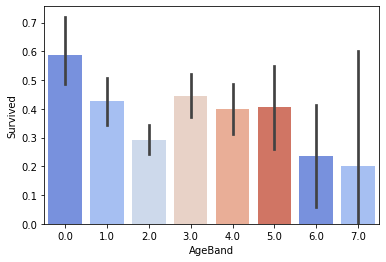

In [ ]:
sns.barplot(x="AgeBand", y="Survived", palette=sns.color_palette("coolwarm"), data=titanic_df)

In [ ]:
createAgeBand(test)
test.AgeBand.isna().any()

False

## Train

In [ ]:
print(titanic_df.isna().sum().any())
print(test.isna().sum().any())

False
True


### SGD Train with `FamilySize` Featrure:

In [ ]:
data_fs = titanic_df[["AgePclass", "Fare", "Mr", "Mrs", "Miss", "Master", "Embarked_s", "Embarked_c", "Embarked_q", "Male", "Female", "FamilySize", "Survived"]]
t_fs = data_fs["Survived"]
x_fs = data_fs.drop('Survived', axis=1)

x_train_fs, x_test_fs, t_train_fs, t_test_fs = sklearn.model_selection.train_test_split(x_fs, t_fs, test_size=0.2, random_state=0)
SGD_cls_fs = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train_fs, t_train_fs)
y_train_prob_fs = SGD_cls_fs.predict_proba(x_train_fs)
y_test_prob_fs = SGD_cls_fs.predict_proba(x_test_fs)


In [ ]:
acurSGD_fs_train = SGD_cls_fs.score(x_train_fs, t_train_fs)
acurSGD_fs_valid = SGD_cls_fs.score(x_test_fs, t_test_fs)
ceSGD_fs_train = metrics.log_loss(t_train_fs, y_train_prob_fs)
ceSGD_fs_valid = metrics.log_loss(t_test_fs, y_test_prob_fs)

print('Accuracy score on train', acurSGD_fs_train)
print('Accuracy score on validation', acurSGD_fs_valid)
print()
print('CE on train', ceSGD_fs_train)
print('CE on test',ceSGD_fs_valid)

Accuracy score on train 0.8300561797752809
Accuracy score on validation 0.8156424581005587

CE on train 0.4187520886749172
CE on test 0.4272816548465031


### SGD Train with `IsAlone` Featrure:

In [ ]:
data_ia = titanic_df[["AgePclass", "Fare", "Mr", "Mrs", "Miss", "Master", "Embarked_s", "Embarked_c", "Embarked_q", "Male", "Female", "IsAlone", "Survived"]]
t_ia = data_ia["Survived"]
x_ia = data_ia.drop('Survived', axis=1)

x_train_ia, x_test_ia, t_train_ia, t_test_ia = sklearn.model_selection.train_test_split(x_ia, t_ia, test_size=0.2, random_state=0)
SGD_cls_ia = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train_ia, t_train_ia)
y_train_prob_ia = SGD_cls_ia.predict_proba(x_train_ia)
y_test_prob_ia = SGD_cls_ia.predict_proba(x_test_ia)

In [ ]:
acurSGD_ia_train = SGD_cls_ia.score(x_train_ia, t_train_ia)
acurSGD_ia_valid = SGD_cls_ia.score(x_test_ia, t_test_ia)
ceSGD_ia_train = metrics.log_loss(t_train_ia, y_train_prob_ia)
ceSGD_ia_valid = metrics.log_loss(t_test_ia, y_test_prob_ia)

print('Accuracy score on train', acurSGD_ia_train)
print('Accuracy score on validation', acurSGD_ia_valid)
print()
print('CE on train', ceSGD_ia_train)
print('CE on test',ceSGD_ia_valid)

Accuracy score on train 0.8019662921348315
Accuracy score on validation 0.7877094972067039

CE on train 0.44656445895453856
CE on test 0.451543034199283


We get better results with `FamilySize` feature and not with `IsAlone` so we will continue with it.

### SGD Train with `AgeBand` Featrure:

In [ ]:
data_ab = titanic_df[["AgePclass", "AgeBand", "Fare", "Mr", "Mrs", "Miss", "Master", "Embarked_s", "Embarked_c", "Embarked_q", "Male", "Female", "FamilySize", "Survived"]]
t_ab = data_ab["Survived"]
x_ab = data_ab.drop('Survived', axis=1)

x_train_ab, x_test_ab, t_train_ab, t_test_ab = sklearn.model_selection.train_test_split(x_ab, t_ab, test_size=0.2, random_state=0)
SGD_cls_ab = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train_ab, t_train_ab)
y_train_prob_ab = SGD_cls_ab.predict_proba(x_train_ab)
y_test_prob_ab = SGD_cls_ab.predict_proba(x_test_ab)

In [ ]:
acurSGD_ab_train = SGD_cls_ab.score(x_train_ab, t_train_ab)
acurSGD_ab_valid = SGD_cls_ab.score(x_test_ab, t_test_ab)
ceSGD_ab_train = metrics.log_loss(t_train_ab, y_train_prob_ab)
ceSGD_ab_valid = metrics.log_loss(t_test_ab, y_test_prob_ab)

print('Accuracy score on train', acurSGD_ab_train)
print('Accuracy score on validation', acurSGD_ab_valid)
print()
print('CE on train', ceSGD_ab_train)
print('CE on test',ceSGD_ab_valid)

Accuracy score on train 0.8314606741573034
Accuracy score on validation 0.8156424581005587

CE on train 0.416162731043784
CE on test 0.414051623054287


We can see that the accuracy is a little bit higher and the loss is a little bit smaller in this model.

### MLP Train with `FamilySize` Featrure:

In [ ]:
MLP_cls_fs = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(x_train_fs, t_train_fs)
y_train_prob_fs = MLP_cls_fs.predict_proba(x_train_fs)
y_test_prob_fs = MLP_cls_fs.predict_proba(x_test_fs)

In [ ]:
acurMLP_fs_train =  MLP_cls_fs.score(x_train_fs, t_train_fs)
acurMLP_fs_valid = MLP_cls_fs.score(x_test_fs, t_test_fs)
ceMLP_fs_train = metrics.log_loss(t_train_fs, y_train_prob_fs)
ceMLP_fs_valid = metrics.log_loss(t_test_fs, y_test_prob_fs)

print('Accuracy score on train', acurMLP_fs_train)
print('Accuracy score on validation', acurMLP_fs_valid)
print()
print('CE on train', ceMLP_fs_train)
print('CE on test',ceMLP_fs_valid)

Accuracy score on train 0.8047752808988764
Accuracy score on validation 0.7877094972067039

CE on train 0.4595387319892355
CE on test 0.429806501053725


### MLP Train with `IsAlone` Featrure:

In [ ]:
MLP_cls_ia = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(x_train_ia, t_train_ia)
y_train_prob_ia = MLP_cls_ia.predict_proba(x_train_ia)
y_test_prob_ia = MLP_cls_ia.predict_proba(x_test_ia)

In [ ]:
acurMLP_ia_train =  MLP_cls_ia.score(x_train_ia, t_train_ia)
acurMLP_ia_valid = MLP_cls_ia.score(x_test_ia, t_test_ia)
ceMLP_ia_train = metrics.log_loss(t_train_ia, y_train_prob_ia)
ceMLP_ia_valid = metrics.log_loss(t_test_ia, y_test_prob_ia)

print('Accuracy score on train', acurMLP_ia_train)
print('Accuracy score on validation', acurMLP_ia_valid)
print()
print('CE on train', ceMLP_ia_train)
print('CE on test',ceMLP_ia_valid)

Accuracy score on train 0.7851123595505618
Accuracy score on validation 0.7821229050279329

CE on train 0.4951636263804779
CE on test 0.4784728945326428


### MLP Train with `AgeBand` Featrure:

In [ ]:
MLP_cls_ab = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=10000).fit(x_train_ab, t_train_ab)
y_train_prob_ab = MLP_cls_ab.predict_proba(x_train_ab)
y_test_prob_ab = MLP_cls_ab.predict_proba(x_test_ab)

In [ ]:
acurMLP_ab_train =  MLP_cls_ab.score(x_train_ab, t_train_ab)
acurMLP_ab_valid = MLP_cls_ab.score(x_test_ab, t_test_ab)
ceMLP_ab_train = metrics.log_loss(t_train_ab, y_train_prob_ab)
ceMLP_ab_valid = metrics.log_loss(t_test_ab, y_test_prob_ab)

print('Accuracy score on train', acurMLP_ab_train)
print('Accuracy score on validation', acurMLP_ab_valid)
print()
print('CE on train', ceMLP_ab_train)
print('CE on test',ceMLP_ab_valid)

Accuracy score on train 0.8117977528089888
Accuracy score on validation 0.7988826815642458

CE on train 0.4502989931578162
CE on test 0.42437388404818


# Compare the Models

In [ ]:
print([acurSGD_fs_train, acurSGD_ia_train, acurSGD_ab_train, acurMLP_fs_train, acurMLP_ia_train, acurMLP_ab_train])
print([acurSGD_fs_valid, acurSGD_ia_valid, acurSGD_ab_valid, acurMLP_fs_valid, acurMLP_ia_valid, acurMLP_ab_valid])
print([ceSGD_fs_train, ceSGD_ia_train, ceSGD_ab_train, ceMLP_fs_train, ceMLP_ia_train, ceMLP_ab_train])
print([ceSGD_fs_valid, ceSGD_ia_valid, ceSGD_ab_valid, ceMLP_fs_valid, ceMLP_ia_valid, ceMLP_ab_valid])


[0.8300561797752809, 0.8019662921348315, 0.8314606741573034, 0.8047752808988764, 0.7851123595505618, 0.8117977528089888]
[0.8156424581005587, 0.7877094972067039, 0.8156424581005587, 0.7877094972067039, 0.7821229050279329, 0.7988826815642458]
[0.4187520886749172, 0.44656445895453856, 0.416162731043784, 0.4595387319892355, 0.4951636263804779, 0.4502989931578162]
[0.4272816548465031, 0.451543034199283, 0.414051623054287, 0.429806501053725, 0.4784728945326428, 0.42437388404818]


In [ ]:
names = ["SGD FamilySize", "SGD IsAlone", "SGD FamilySize-AgeBand", "MLP FamilySize", "MLP IsAlone", "MLP FamilySize-AgeBand"]
train_acur = [acurSGD_fs_train, acurSGD_ia_train, acurSGD_ab_train, acurMLP_fs_train, acurMLP_ia_train, acurMLP_ab_train]
valid_acur = [acurSGD_fs_valid, acurSGD_ia_valid, acurSGD_ab_valid, acurMLP_fs_valid, acurMLP_ia_valid, acurMLP_ab_valid]
train_loss = [ceSGD_fs_train, ceSGD_ia_train, ceSGD_ab_train, ceMLP_fs_train, ceMLP_ia_train, ceMLP_ab_train]
valid_loss = [ceSGD_fs_valid, ceSGD_ia_valid, ceSGD_ab_valid, ceMLP_fs_valid, ceMLP_ia_valid, ceMLP_ab_valid]

df = pd.DataFrame(list(zip(names, train_acur, valid_acur, train_loss, valid_loss)), columns = ['Name', 'Train_accuracy', 'Validation_accuracy', 'Train_loss', 'Validation_loss'])

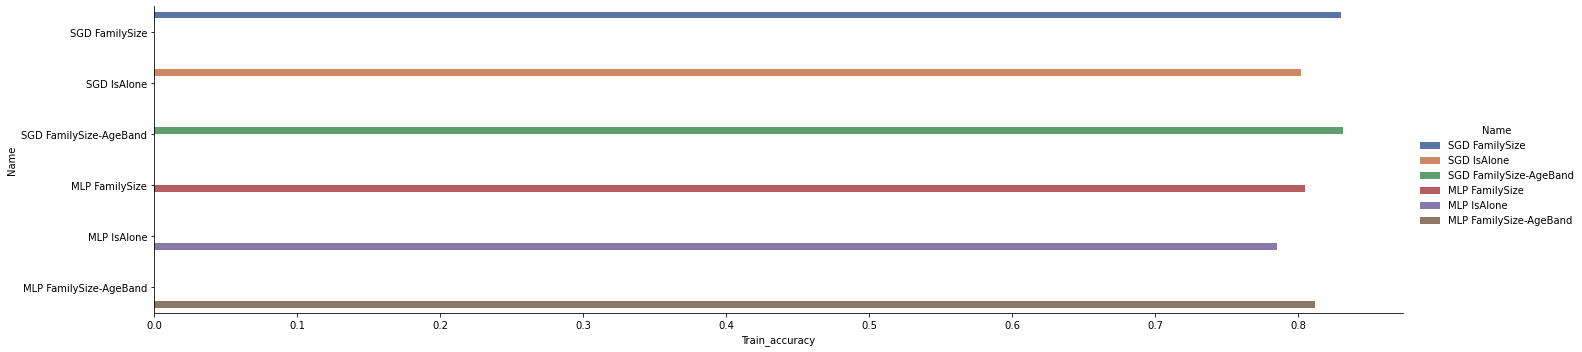

In [ ]:
sns.catplot(x="Train_accuracy", y="Name", hue="Name", kind="bar", palette=sns.color_palette("deep"), data=df, height=5, aspect=4)

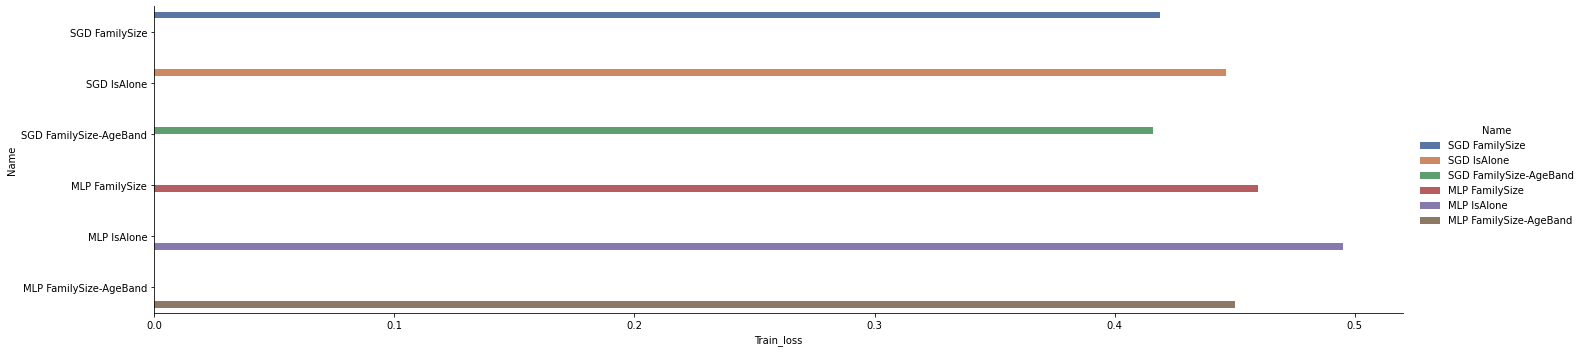

In [ ]:
sns.catplot(x="Train_loss", y="Name", hue="Name", kind="bar", palette=sns.color_palette("deep"), data=df, height=5, aspect=4)

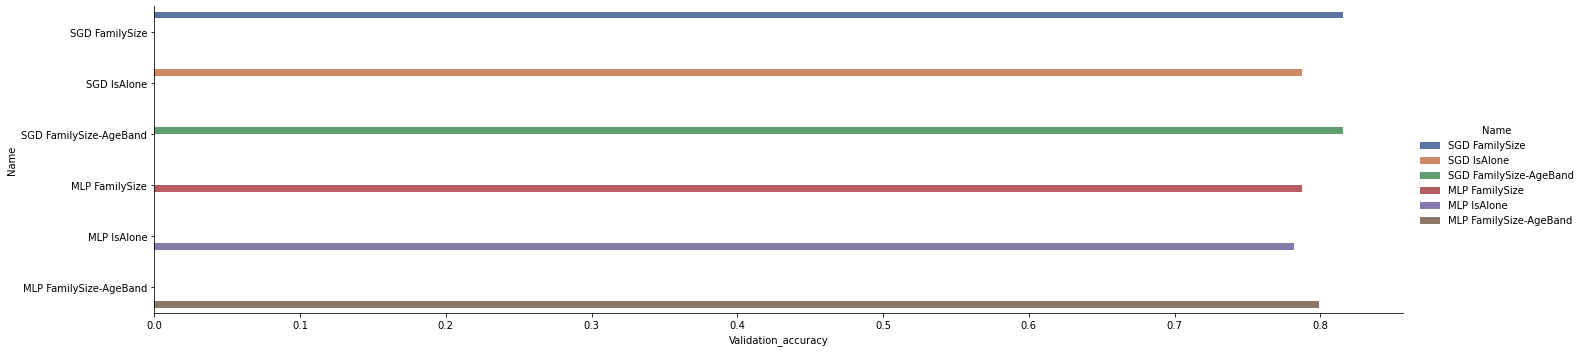

In [ ]:
sns.catplot(x="Validation_accuracy", y="Name", hue="Name", kind="bar", palette=sns.color_palette("deep"), data=df, height=5, aspect=4)

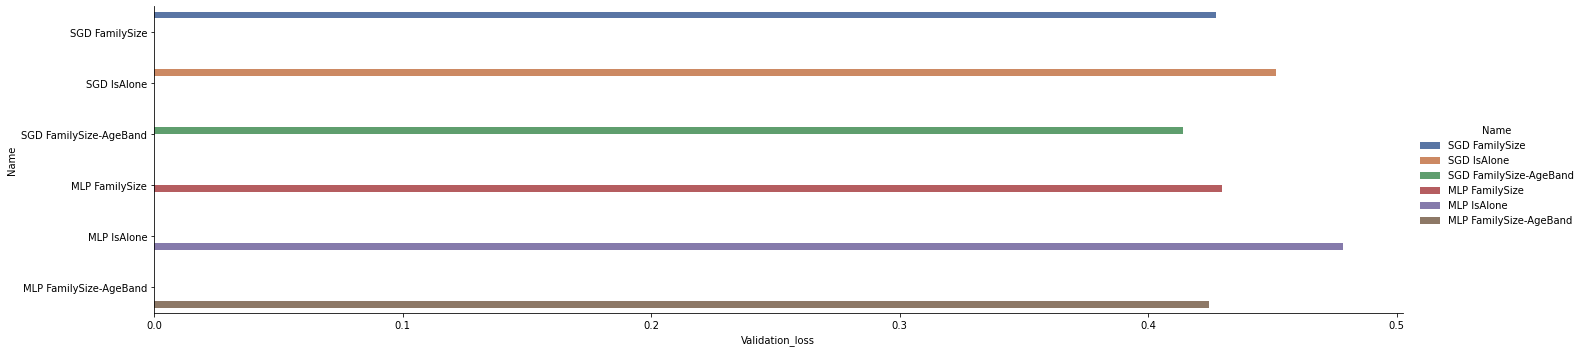

In [ ]:
sns.catplot(x="Validation_loss", y="Name", hue="Name", kind="bar", palette=sns.color_palette("deep"), data=df, height=5, aspect=4)

We can see that the best train results was with SGD with `AgeBand` feature.  
The best validation results was with SGD with `AgeBand` feature as well.  
Also, the smallest loss (train, and validation) was with SGD with `AgeBand` feature.  
So we will use this model with the test.

# Test

The test dataset missing one value in `Fare` variable, we will fill it with the mean of passengers with the same `Pclass`, `Title_cat`.

In [ ]:
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
test.Fare.isna().any()

False

In [ ]:
test_ac = test[["AgePclass", "AgeBand", "Fare", "Mr", "Mrs", "Miss", "Master", "Embarked_s", "Embarked_c", "Embarked_q", "Male", "Female", "FamilySize"]]

y_pred = SGD_cls_ab.predict(test_ac)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Score

![](https://user-images.githubusercontent.com/52006798/99272182-2b9a3600-2830-11eb-9432-a078aad8da1c.jpg)
![](https://user-images.githubusercontent.com/52006798/99245606-85890480-280c-11eb-8ac3-c0783006dacf.jpg)
![](https://user-images.githubusercontent.com/52006798/99245667-a2bdd300-280c-11eb-8149-dcd446f4e8d5.jpg)

# Links


* Fill `Embarked` missing values with the most common values. [Suggested here](https://www.kaggle.com/startupsci/titanic-data-science-solutions#Completing-a-categorical-feature)

* Create `Title` feature instead of `Name`. [Suggested here](https://www.kaggle.com/startupsci/titanic-data-science-solutions#Creating-new-feature-extracting-from-existing)

* Drop `PassengerId`, `Cabin` and `Ticket`. [Suggested here](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#3.22-Clean-Data)

* Dropping `SibSp` and `Parch` in favor for `FamilySize` feature. [Suggested here](https://www.kaggle.com/startupsci/titanic-data-science-solutions#Create-new-feature-combining-existing-features)

* Consider `isAlone` feature instead of `SibSp`, `Parch` and `FamilySize`. [Suggested here](https://www.kaggle.com/startupsci/titanic-data-science-solutions#Create-new-feature-combining-existing-features)

* Consider change `Age` into an ordinal variable based on age ranges. [Suggested here](https://www.kaggle.com/startupsci/titanic-data-science-solutions#Create-new-feature-combining-existing-features)